# Reducing ill conditioned Markov Chains with Graph Transformation (GT)

This cell loads our `PyGT` package, `tqdm` for progress bars, and defines some helper functions

In [33]:
!pip install PyGT tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
import os.path as Path
from PyGT.io import load_ktn
from PyGT.GT import blockGT
from PyGT.mfpt import full_MFPT_matrix
from PyGT.stats import compute_passage_stats as fpt
from scipy.sparse.linalg import eigs,inv,spsolve

from scipy.sparse import diags,eye,issparse
from tqdm.notebook import tqdm

def ev(Q):
    nu = spla.eigvals(Q)
    return np.sort(-nu.real)

def select_states_to_remove(B_matrix,participation):
    N_states = B_matrix.shape[0]
    denseB = np.zeros(B.shape)
    B.todense(out=denseB)

    connections = denseB>0

    rm_vec = np.ones(N_states,bool)

    for i in range(N):
        # boundary nodes
        if not (participation[connections[i]]==participation[i]).min():
            rm_vec[i] = False

        # local minima
        if (u)[participation == participation[i]].min()==(u)[i]:
            rm_vec[i] = False
    print(f"""
        Retained Nodes: {N_states-rm_vec.sum()}
    """)
    return rm_vec

def condition_number_estimation(Q):
    if issparse(Q):
        MQ = Q.todense().copy()
    else:
        MQ = Q.copy()
    MQ -= np.diag(np.diag(MQ))
    return np.linalg.cond(MQ)

def es_compute_passage_stats(A_sel, B_sel, pi, K, dopdf=True,rt=None):
    r"""Compute the A->B and B->A first passage time distribution,
    first moment, and second moment using eigendecomposition of a CTMC
    rate matrix.

    Parameters
    ----------
    A_sel : (N,) array-like
        boolean array that selects out the A nodes
    B_sel : (N,) array-like
        boolean array that selects out the B nodes
    pi : (N,) array-like
        stationary distribution
    K : (N, N) array-like
        CTMC rate matrix

    dopdf : bool, optional
        Do we calculate full fpt distribution or just the moments. Defaults=True.
    rt: array, optional
        Vector of times to evaluate first passage time distribution in multiples
        of :math:`\left<t\right>` for A->B and B->A. If ``None``, defaults to a logscale
        array from :math:`0.001\left<t\right>` to :math:`1000\left<t\right>`
        in 400 steps, i.e. ``np.logspace(-3,3,400)``.
        Only relevant if ``dopdf=True``

    Returns
    -------
    tau : (4,) array-like
        First and second moments of first passage time distribution for A->B and B->A [:math:`\mathcal{T}_{\mathcal{B}\mathcal{A}}`, :math:`\mathcal{V}_{\mathcal{B}\mathcal{A}}`, :math:`\mathcal{T}_{\mathcal{A}\mathcal{B}}`, :math:`\mathcal{V}_{\mathcal{A}\mathcal{B}}`]
    pt : ( len(rt),4) array-like
        time and first passage time distribution p(t) for A->B and B->A

    """
    #multiply by negative 1 so eigenvalues are positive instead of negative
    Q=-K
    if rt is None:
        rt = np.logspace(-3,3,400)
    #<tauBA>, <tau^2BA>, <tauAB>, <tau^2AB>
    tau = np.zeros(4)
    if dopdf:
        # time*tau_range, p(t) (first 2: A->B, second 2: B->A)
        pt = np.zeros((4,len(rt)))

    #A -> B
    #P(0) is initialized to local boltzman of source community A
    rho = pi * A_sel
    rho /= rho.sum()
    #B is absorbing, so we want Q in space of A U I
    M = Q[~B_sel,:][:,~B_sel]
    x = spsolve(M,rho[~B_sel])
    y = spsolve(M,x)
    # first moment tau(A->B) = 1.Q^{-1}.rho(A) = 1.x
    tau[0] = x.sum()
    # second moment = 2 x 1.Q^{-2}.rho = 2.0* 1.Q^{-1}.x
    tau[1] = 2.0*y.sum()
    if dopdf:
        #time in multiples of the mean first passage time
        pt[0] = rt*tau[0]
        #nu=eigenvalues, v=left eigenvectors, w=right eigenvectors
        nu,v,w = spla.eig(M.todense(),left=True)
        #print(nu[0])
        #sort eigenvalues
        nu_sorted = sorted(nu)
        tau_m = 1/(nu_sorted[1]-nu_sorted[0])
        print("tau_m/TAU_AB " + str(tau_m/tau[0]))
        #print("mixing time " + str(tau_m))
        #print("lambda0*tau_m " + str(nu_sorted[0]*tau_m))
        #normalization factor
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        #dot product (v.P(0)=rho)
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~B_sel])
        #dot product (1.T.w)
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        #(v*w/nu).sum() is the same as <tau>, the first bit is the pdf p(t)
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))#*(v*w/nu).sum()

    #B -> A
    rho = pi * B_sel
    rho /= rho.sum()
    M = Q[~A_sel,:][:,~A_sel]
    x = spsolve(M,rho[~A_sel])
    y = spsolve(M,x)
    tau[2] = x.sum()
    tau[3] = 2.0*y.sum()
    if dopdf:
        pt[2] = rt*tau[2]
        nu,v,w = spla.eig(M.todense(),left=True)
        #sort eigenvalues
        nu_sorted = sorted(nu)
        tau_m = 1/(nu_sorted[1]-nu_sorted[0])
        print("tau_m/TAU_AB " + str(tau_m/tau[2]))
        #print("mixing time " + str(tau_m))
        #print("lambda0*tau_m " + str(nu_sorted[0]*tau_m))
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~A_sel])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))#*(v*w/nu).sum()
        return tau, pt.T
    else:
        return tau




DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


## Load 9-macrostate model and BACE-defined community participation

In [41]:
data_path = 'example-data-9-communities/'

T = 1e1

B, K, tau, N, u, s, Emin, retained = \
  load_ktn(path=data_path,beta=1.0/T,screen=True)

Q = K-diags(1.0/tau)

full_cond = condition_number_estimation(B)
print(f"""
    Estimated condition number of B: {full_cond}
    """)

pi = np.exp(-u/T+s)
print("pi " + str(pi))
pi /= pi.sum()



communities = \
  np.loadtxt(Path.join(data_path,'communities_bace9.dat')).astype(int)


for ic in zip(*np.unique(communities,return_counts=True)):
    print("\tCommunity",ic[0]+1,":",ic[1],"states")



	Connected Clusters: 1, of which 95% have <= 994 states
	Retaining largest cluster with 994 nodes


    Estimated condition number of B: 18376.672773310373
    
pi [0.10281214 0.73376105 0.17946737 0.1287411  0.08710493 0.02577831 0.11746066 0.12832594 0.11385474 0.0842976  0.04816745 0.42059082 0.4293895  0.03533215
 0.72494474 0.09760936 0.87130355 0.64315093 0.06205452 0.16218594 0.05705316 0.04197749 0.09963997 0.84936281 0.07738504 0.11951757 0.02179223 0.07340951
 0.22773062 0.0979516  0.22838286 0.05572804 0.55474382 0.08677803 0.05825404 0.55456578 0.26972783 0.13011041 0.06225217 0.07874253 0.10843961 0.34942307
 0.24577671 0.23041532 0.29492274 0.16568252 0.1960919  0.28558606 0.06673125 0.81164449 0.1267027  0.34202144 0.03175669 0.15353575 0.02579404 0.03145832
 0.02323904 0.19088734 0.14430995 0.33778629 0.37933337 0.11098704 0.03657604 0.08372716 0.38644766 0.38827988 0.1665713  0.37358047 0.78312978 0.22095597
 0.34362242 0.08364348 0.11971374 0.54816779 0.82755737 0.33

## Find boundary nodes and community minima, then perform GT reduction

(2, 215)

In [42]:
# boolean vector of states to remove
rm_vec = select_states_to_remove(B,communities)

retained_states = ~rm_vec.copy()
#print(retained_states)

# block GT reduction
r_B, r_tau, r_Q = blockGT(rm_vec,B,tau,block=50,rates=True,screen=True)

r_Q_d = r_Q.toarray()
print("r_Q_d " + str(r_Q_d))
print("shape " + str(r_Q_d.shape))
#if issparse(r_Q):
    #r_Q_d = r_Q.todense().copy()

    
#print(r_Q_d.shape)
#print("r_Q_d " + str(r_Q_d))
#print("r_Q_d[0][0] " +  str(r_Q_d[0]))
#print(r_Q_d[0].shape)
#print("rQ_d " + str(r_Q_d))
#print("################################")

#r_tau: array of renormalised waiting times
#tau: array of full network waiting times
r_pi = pi[retained_states] * r_tau / tau[retained_states]
#Normalising r_pi
r_pi = r_pi/r_pi.sum()

#Saving the stationary distribution for reduced network to file
np.savetxt(Path.join(data_path, 'esmae_reduced_stat_prob.dat'), np.log(r_pi),fmt="%.16f")
#Saving the stationary distribution for full network to file
np.savetxt(Path.join(data_path, 'esmae_full_stat_prob.dat'), np.log(pi),fmt="%.16f")


r_ids = np.arange(communities.size)[retained_states] 
r_communities = communities[retained_states]

#Producing community files for reduced network
#Open all comms files
COMM_PATTERN = data_path + "esmae_reduced_comms"
FULL_COMM_PATTERN = data_path + "esmae_full_comms"
all_comms = np.arange(9)
cfiles = []
fcfiles = []
for ci in range(len(all_comms)):
        cfilename=COMM_PATTERN+str(all_comms[ci])+".dat"
        fcfilename=FULL_COMM_PATTERN+str(all_comms[ci])+".dat"
        print(cfilename)
        cfile = open(cfilename,"w")
        cfiles.append(cfile)
        fcfile = open(fcfilename, "w")
        fcfiles.append(fcfile)
        
        
for i in range(len(r_communities)):
    c = r_communities[i]
    node = i+1
    cfiles[c-1].writelines(str(node) + '\n')
for i in range(len(communities)):
    c = communities[i]
    node = i+1
    fcfiles[c-1].writelines(str(node)+'\n')
    
for file in cfiles:
    file.close()
for file in fcfiles:
    file.close()
    
#np.savetxt(Path.join,'esmae_reduced_comms' + str(i) + '.dat'), np.stack(

# save files
np.savetxt(Path.join(data_path,'esmae_reduced_communities_bace9.dat'),
           np.stack((r_ids + 1,r_communities)).T,fmt="%d %d",header="NB: nodes are indexed from one, communities are 0-indexed !")
np.savetxt(Path.join(data_path,'esmae_reduced_bace9.dat'),
           r_ids + 1, fmt="%d")
#save edge_conns.dat and edge_weights.dat files for discotress

connA = []
connB = []
r1 = []
r2 = []

        
for i in range(retained_states.sum()):
    for j in range(retained_states.sum()):
        if r_Q_d[i][j]:
            if i<j: 
                connA.append(i+1)
                connB.append(j+1)
                r1.append(np.log(r_Q_d[i][j]))
                r2.append(np.log(r_Q_d[j][i]))
                
                #print("i:" + str(i) + " j:" + str(j) + " " + str(r_Q_d[i][j]))
                
np.savetxt(Path.join(data_path, 'esmae_reduced_edge_conns.dat'), np.stack((connA, connB)).T,fmt="%d %d")
#print('{:<10s}{:>4s}{:>12s}{:>12s}'.format(data[i][0],data[i][1],data[i][2],data[i][3]))
np.savetxt(Path.join(data_path, 'esmae_reduced_edge_weights.dat'), np.stack((r2, r1)).T, fmt="%.16f %.16f", delimiter=' ')

r_full_cond = condition_number_estimation(r_B)
print(f"""
    Estimated condition number of    B: {full_cond:.2f}
    Estimated condition number of GT_B: {r_full_cond:.2f} 
""")


        Retained Nodes: 215
    


GT:   0%|          | 0/779 [00:00<?, ?it/s]

GT removed 779 nodes in 0.073 seconds with 0 floating point corrections
r_Q_d [[-1.66605962e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.10175783e-01  0.00000000e+00 ...  0.00000000e+00  1.31871341e-08  3.15455810e-08]
 [ 0.00000000e+00  0.00000000e+00 -4.18921601e-01 ...  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.43555985e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.34270463e-08  0.00000000e+00 ...  0.00000000e+00 -8.46449015e-01  5.95916451e-02]
 [ 0.00000000e+00  4.57922913e-08  0.00000000e+00 ...  0.00000000e+00  8.49589537e-02 -6.69618056e-01]]
shape (215, 215)
example-data-9-communities/esmae_reduced_comms0.dat
example-data-9-communities/esmae_reduced_comms1.dat
example-data-9-communities/esmae_reduced_comms2.dat
example-data-9-communities/esmae_reduced_comms3.dat
example-data-9-communities/esmae_reduced_comms4.dat
example-data-9-commun

## First passage time distributions


  0%|          | 0/6 [00:00<?, ?it/s]

cA:3 cB:2
full network
reduced network
cA:4 cB:2
full network
reduced network
cA:4 cB:3
full network
reduced network
cA:5 cB:2
full network
reduced network
cA:5 cB:3
full network
reduced network
cA:5 cB:4
full network
reduced network


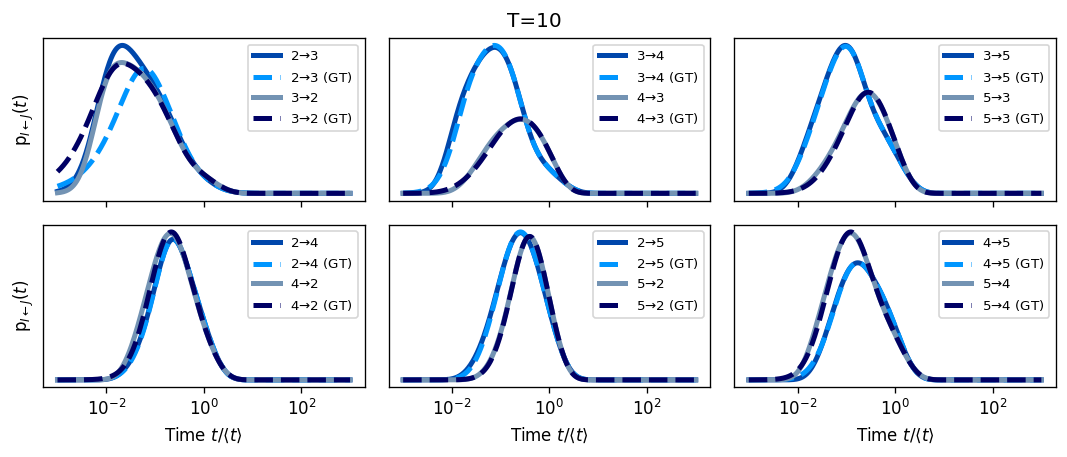

In [43]:
#Options for initial state are:
#uni: uniform for full network and reduced network across full B
#uni2: uniform for full network and reduced network on B states that are in reduced network
#stat: stationary distribution
#globmin: All probability on global minimum of B
init_state = "globmin" 

fig,axs = plt.subplots(2,3,figsize=(9,4),dpi=120,sharex='col')
fig.patch.set_facecolor('white')
cc = 0
pbar = tqdm(total=6)
for cA in range(2,6):
    for cB in range(2,6):
        if cA>cB:
            #Communities are labelled 0...8
            A_sel = communities==cA-1 #Numpy array of True and Falses for each node, True if in community cA
            B_sel = communities==cB-1
            r_A_sel = A_sel[retained_states]
            r_B_sel = B_sel[retained_states]
            fr_A_sel = A_sel
            for i in range(0,len(fr_A_sel)):
                if not retained_states[i]:
                    fr_A_sel=False
                    
            #print("retained states " + str(retained_states))

            #Uniform distribution
            #Full network
            p_0_uni = np.zeros(pi.shape)
            p_0_uni[A_sel] = 1/A_sel.sum()
            p_0_uni[B_sel] = 1/B_sel.sum()
            #print("sum should be 2 " + str(p_0_uni.sum()))
            #reduced network
            r_p_0_uni = np.zeros(retained_states.sum())
            r_p_0_uni[r_A_sel] = 1/r_A_sel.sum()
            r_p_0_uni[r_B_sel] = 1/r_B_sel.sum()
            #print("sum should be 2 " + str(r_p_0_uni.sum()))
            #Full network uniform but only for reduced nodes
            p_0_uni2 = np.zeros(pi.shape)
            p_0_uni2[retained_states] = r_p_0_uni
            #p_0_uni2[A_sel] *= 1/r_A_sel.sum()
            #p_0_uni2[B_sel] *= 1/r_B_sel.sum()
            #p_0_uni2[!retained_states] = 0.0
            #print("p_0_uni2 " + str(p_0_uni2))
            #print("sum should be 2 " + str(p_0_uni2.sum()))
            #Stationary distribution but only for reduced nodes
            pi_2 = np.zeros(pi.shape)
            pi_2[retained_states] = r_pi
            
        
        
            # define initial distribution as in paper
            p_0 = np.zeros(pi.shape)
            p_0[A_sel] = np.arange(A_sel.sum()) == pi[A_sel].argmax() #RHS: Index of minimum of A_sel community
            p_0[B_sel] = np.arange(B_sel.sum()) == pi[B_sel].argmax()

            # define same quantities for GT reduced system
            r_p_0 = p_0[retained_states]
            r_A_sel = A_sel[retained_states]
            r_B_sel = B_sel[retained_states]

            # mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            #print("p_0 " + str(p_0))
            
            #Setting the initial state
            if init_state=="uni":
                pi_init = p_0_uni
                r_pi_init = r_p_0_uni
            elif init_state=="uni2":
                pi_init = p_0_uni2
                r_pi_init = r_p_0_uni
            elif init_state=="stat":
                pi_init = pi
                r_pi_init = r_pi
            elif init_state=="stat2":
                pi_init = pi_2
                r_pi_init = r_pi
            elif init_state=="globmin":
                pi_init = p_0
                r_pi_init = r_p_0
            else:
                print("Error incorrect initial state")
            print("cA:" + str(cA) + " cB:" + str(cB))
            print("full network")
            mfpt,fptd = fpt(A_sel=A_sel,B_sel=B_sel,pi=pi_init,K=Q,dopdf=True)
            #print("fptd[:,0] ")
            #print(fptd[:,0])
            #print(len(fptd[:,0]))

            print("reduced network")
            # r_mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            #print("r_p_0 " + str(r_p_0))
            r_mfpt,r_fptd = \
                fpt(A_sel=r_A_sel,B_sel=r_B_sel,pi=r_pi_init,K=r_Q,dopdf=True)
            #print("CA " + str(cA))
            #print("CB " + str(cB))
            #print("r_mfpt " + str(r_mfpt))
            #Saving reduced data to file
            
            np.savetxt("data/mean" + str(cA) + str(cB) + "_" + init_state + "_" + str(T) + ".dat",np.stack((mfpt,r_mfpt)))
            i,j = cc%2,cc//2
            #print(i)
            #print(j)


            np.savetxt("data/fpt_py_r" + str(cA) + str(cB) + "_" + init_state + ".dat",np.stack((r_fptd[:,3],r_fptd[:,2])).T)
            np.savetxt("data/fpt_py_r" + str(cB) + str(cA) + "_" + init_state + ".dat",np.stack((r_fptd[:,1],r_fptd[:,0])).T)
            np.savetxt("data/fpt_py_" + str(cA) + str(cB) + "_" + init_state + ".dat",np.stack((fptd[:,3],fptd[:,2])).T)
            np.savetxt("data/fpt_py_" + str(cB) + str(cA) + "_" + init_state + ".dat",np.stack((fptd[:,1],fptd[:,0])).T)                        
            axs[i,j].semilogx(fptd[:,2]/mfpt[2],fptd[:,3],lw=3,color=(0,71/255,171/255),
                            label=fr"{cB}$\to${cA}")
            axs[i,j].semilogx(r_fptd[:,2]/r_mfpt[2],r_fptd[:,3],'--',lw=3,color=(0,150/255,255/255),
                            label=fr"{cB}$\to${cA} (GT)")

            axs[i,j].semilogx(fptd[:,0]/mfpt[0],fptd[:,1],lw=3,color=(115/255,147/255,179/255),
                            label=fr"{cA}$\to${cB}")
            axs[i,j].semilogx(r_fptd[:,0]/r_mfpt[0],r_fptd[:,1],'--',lw=3,color=(0,0,100/255),
                            label=fr"{cA}$\to${cB} (GT)")

            axs[i,j].set_yticks([])
            if i==0:
                axs[i,j].set_xticks([])
            else:
                axs[i,j].set_xlabel(r"Time $t/\langle{t}\rangle$")

            if j==0:
                axs[i,j].set_ylabel(r"${\rm p}_{I\leftarrow J}(t)$")

            axs[i,j].legend(fontsize=8)
            cc+=1
            pbar.update(1)
#plt.suptitle( "Selected first passage distributions for 9-community model,"
 # f" T={int(T)} Initial state={str(init_state)}",y=0.94)
plt.suptitle(f"T={int(T)}", y=0.94)
plt.subplots_adjust(wspace=0,hspace=0)
plt.tight_layout()
plt.savefig(f"figures/pdf_comp_T{int(T)}_{init_state}_paper.pdf")
plt.show()